<a href="https://colab.research.google.com/github/romerocruzsa/hpc_accelerated_imaging/blob/main/accelerated_training_strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import lilbraries

In [ ]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random as rand
import seaborn as sns
sns.set()

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models, transforms

import os
import pandas as pd
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from torchvision import models
import time
from mpi4py import MPI

import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

In [ ]:
!git clone https://github.com/hardik0/AI-for-Medicine-Specialization
%cd AI-for-Medicine-Specialization/AI-for-Medical-Diagnosis/
%ls nih/

fatal: destination path 'AI-for-Medicine-Specialization' already exists and is not an empty directory.
/content/AI-for-Medicine-Specialization/AI-for-Medical-Diagnosis
densenet.hdf5  images_small/  pretrained_model.h5  test.csv  train-small.csv  valid-small.csv


# Part 1

In [ ]:
def load_dataframe(filepath):
  df = pd.read_csv(filepath)
  print(f"Filepath: {filepath} \tRows: {df.shape[0]} \tColumns: {df.shape[1]}")
  return df

def data_statistics(data, imgs_path, info=None, show_img=None, random=True, analyze_single=None):
  id = True
  if info == True:
    print(data.info())
  if show_img == 0:
    plot_images(data, imgs_path, analyze_single=analyze_single)
  if show_img == 1:
    plot_images(data, imgs_path, colorscale='gray', analyze_single=analyze_single)

def plot_images(data, imgs_path, colorscale=None, analyze_single=None):
  imgs = data['Image'].values
  img_count = 6
  rand_imgs = [np.random.choice(imgs) for i in range(img_count)]

  plt.figure(figsize=(20,10))

  if analyze_single == True:
    rand_id = rand.randint(0,img_count-1)
    analyze_single_image(rand_imgs[rand_id], imgs_path, single_colorscale=colorscale)

  else:
    print(f"Displaying {img_count} images...")
    for i in range(img_count):
      plt.subplot(2, 3, i+1)
      img_block = plt.imread(os.path.join(imgs_path, rand_imgs[i]))
      if colorscale == 'gray':
        plt.imshow(img_block, cmap='gray') # Add cmap = 'gray' for grayscale image
      else:
        plt.imshow(img_block) # Add cmap = 'gray' for grayscale image
    plt.tight_layout()
    plt.show()

def analyze_single_image(data, imgs_path, single_colorscale=None):
  raw_image = plt.imread(os.path.join(imgs_path, data))

  plt.figure(figsize=(20,7)) # specifying the overall grid size

  if single_colorscale == 'gray':
    plot_image_hist(raw_image, single_colorscale=single_colorscale)

  else:
    plot_image_hist(raw_image)

def plot_image_hist(img, single_colorscale=None):
    plt.subplot(1, 2, 1)
    if single_colorscale == 'gray':
      plt.imshow(img, cmap=single_colorscale)
    else:
      plt.imshow(img)
    plt.colorbar()
    plt.title('Raw Chest X Ray Image')

    plt.subplot(1, 2, 2)
    sns.histplot(img.ravel(),
                label=f'Pixel Mean {np.mean(img):.4f} & Standard Deviation {np.std(img):.4f}', kde=False, color='skyblue')
    sns.set_style(style='white')
    plt.legend(loc='upper center')
    plt.title('Distribution of Pixel Intensities in the Image')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('# Pixels in Image')

    plt.tight_layout()
    plt.show()

import time
from IPython.display import display

def timed_execution(start_time, end_time):
    elapsed_time = end_time - start_time
    print(f"Elapsed Time: {elapsed_time} seconds\n{result}")


In [ ]:
train_data = load_dataframe("nih/train-small.csv")
# val_data = load_dataframe("nih/valid-small.csv")
test_data = load_dataframe("nih/test.csv")

all_data = pd.concat([train_data, test_data]).drop_duplicates()

Filepath: nih/train-small.csv 	Rows: 1000 	Columns: 16
Filepath: nih/test.csv 	Rows: 420 	Columns: 16


In [ ]:
# Paths
main_folder = "/content/AI-for-Medicine-Specialization/AI-for-Medical-Diagnosis/nih/"
images_folder = "images_small/"
subfolders = ["train-small", "valid-small", "test"]

csv_files = ["train-small.csv", "valid-small.csv", "test.csv"]

# Create subfolders if they don't exist
for split in ["train-small", "valid-small", "test"]:
    split_folder = os.path.join(main_folder, images_folder, split)
    os.makedirs(split_folder, exist_ok=True)

# Read CSV files
dfs = {os.path.splitext(csv_file)[0]: pd.read_csv(os.path.join(main_folder, csv_file)) for csv_file in csv_files}

# Iterate through image files
for split, df in dfs.items():
  for index, row in df.iterrows():
    image_filename = f"{row['Image']}"
    source_path = os.path.join(main_folder, images_folder, image_filename)
    # print('\nSOURCE ', source_path)
    destination_folder = os.path.join(main_folder, images_folder, split)
    # print('\nDEST FOLDER ', destination_folder)
    destination_path = os.path.join(destination_folder, image_filename)
    # print('\nDEST PATH ', destination_path)

    # Copy the image file to the corresponding subfolder
    try:
      shutil.copy(source_path, destination_path)
    except FileNotFoundError:
      pass

print("Images moved to subfolders successfully.")

for subfolder in subfolders:
    folder_path = os.path.join(main_folder, images_folder, subfolder)

    # List all items (files and subdirectories) in the subfolder
    items = os.listdir(folder_path)

    # Filter out only PNG files
    png_files = [item for item in items if item.lower().endswith(".png")]

    # Print the list of PNG files
    print(f"Contents of the '{subfolder}' subfolder: {len(png_files)}")


Images moved to subfolders successfully.
Contents of the 'train-small' subfolder: 1000
Contents of the 'valid-small' subfolder: 200
Contents of the 'test' subfolder: 420


In [ ]:
print(f"The total patient ids are {train_data['PatientId'].count()}, from those the unique ids are {train_data['PatientId'].value_counts().shape[0]} ")

# Get data columns
columns = train_data.keys()
columns = list(columns)

# Remove unnecesary elements
columns.remove('Image')
columns.remove('PatientId')

# Get the total classes
print(f"There are {len(columns)} columns of labels for these conditions: {columns}")

The total patient ids are 1000, from those the unique ids are 928 
There are 14 columns of labels for these conditions: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [ ]:
# Print out the number of positive labels for each class
for column in columns:
    print(f"The class {column} has {train_data[column].sum()} samples")

The class Atelectasis has 106 samples
The class Cardiomegaly has 20 samples
The class Consolidation has 33 samples
The class Edema has 16 samples
The class Effusion has 128 samples
The class Emphysema has 13 samples
The class Fibrosis has 14 samples
The class Hernia has 2 samples
The class Infiltration has 175 samples
The class Mass has 45 samples
The class Nodule has 54 samples
The class Pleural_Thickening has 21 samples
The class Pneumonia has 10 samples
The class Pneumothorax has 38 samples


Displaying 6 images...


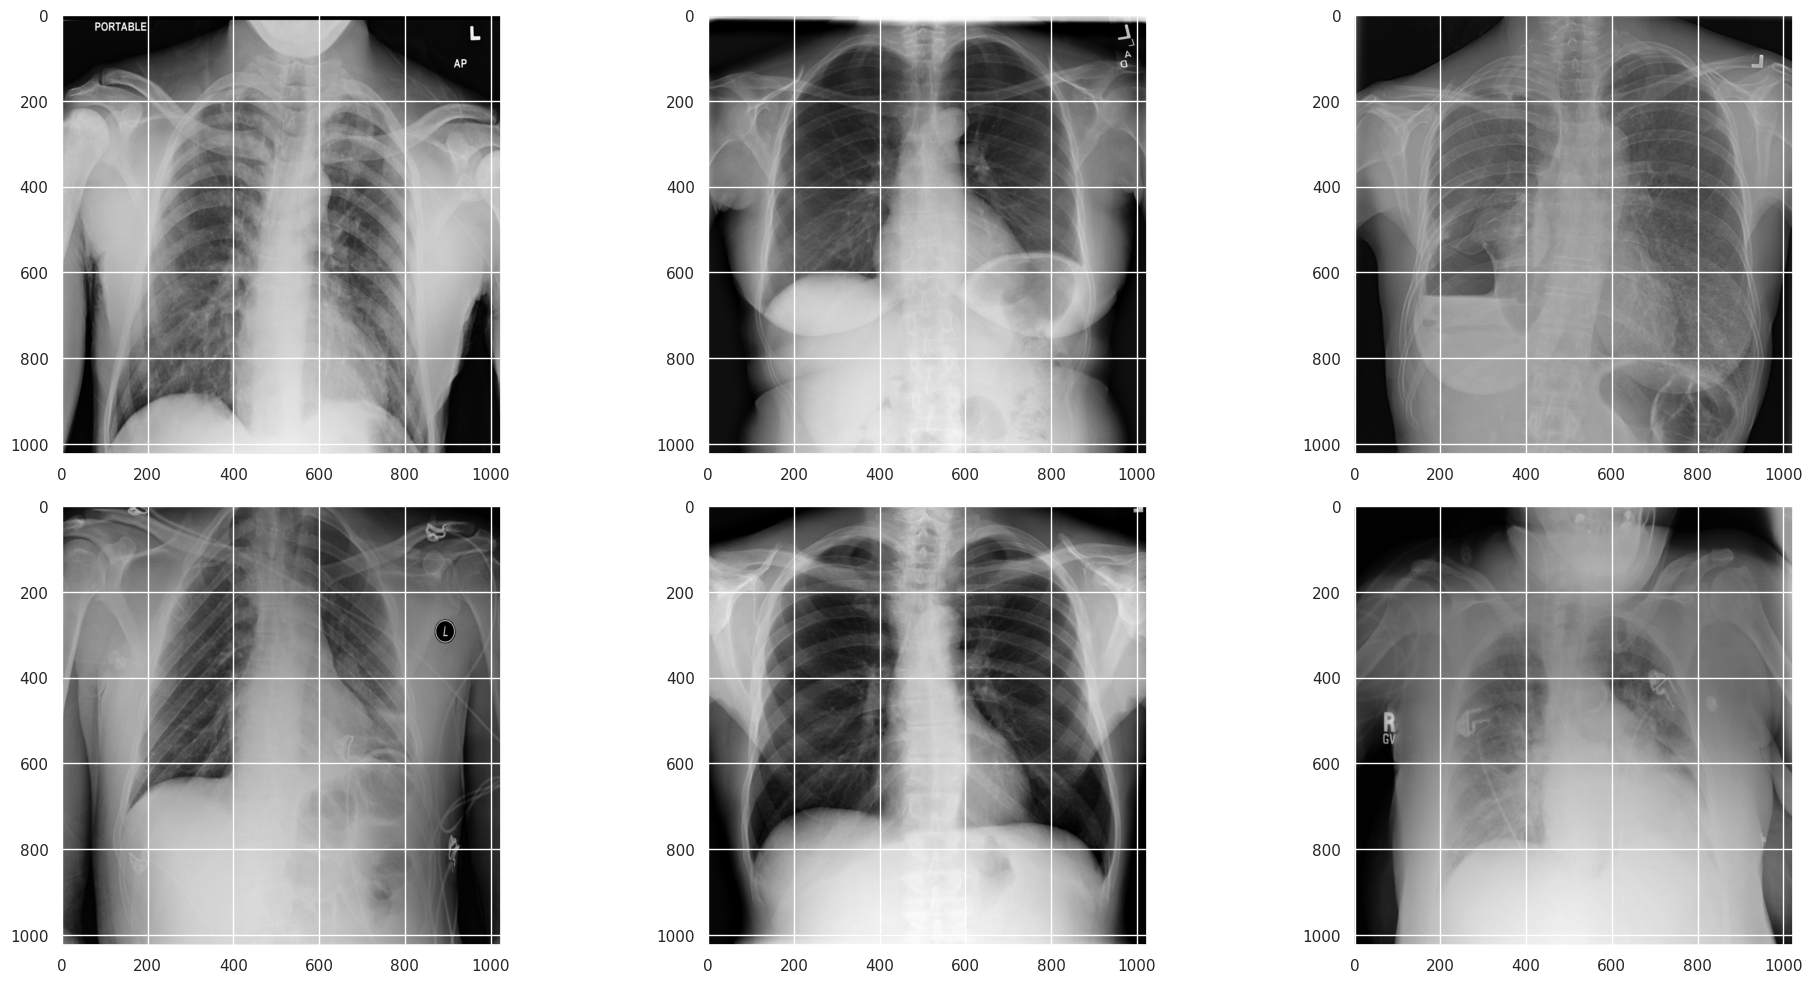

In [ ]:
data_statistics(train_data, "nih/images_small", show_img=1, analyze_single=False)

<Figure size 2000x1000 with 0 Axes>

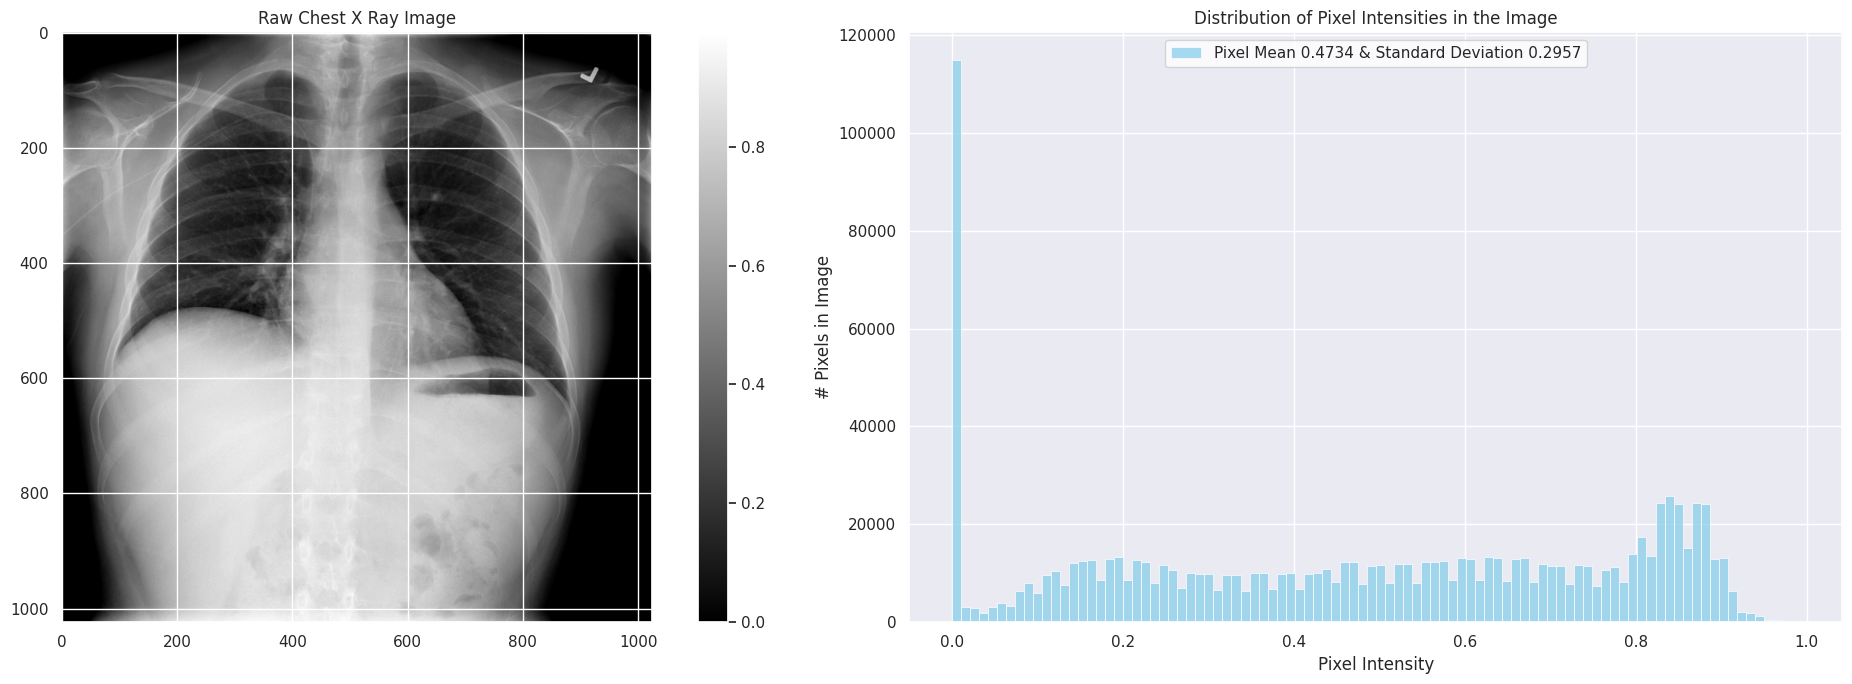

In [ ]:
data_statistics(train_data, "nih/images_small", show_img=1, analyze_single=True)

# Part 2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.functional as T
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, root_dir, data, subset=None, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = os.listdir(root_dir)
        self.data = data
        self.subset = subset

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.file_list[idx])
        image = Image.open(img_name).convert('RGB')  # Adjust the mode based on your images

        labels = self.data.loc[self.data['Image'] == self.file_list[idx]]

        # if labels.empty:
          # skip to next iteration? Means that the image we have loaded is not part of the data csv we used.

        if ('Image' in labels) or ('PatientId' in labels):
          labels = self.data.loc[self.data['Image'] == self.file_list[idx]].drop(columns=['Image','PatientId'])
          labels = labels.values

        if self.transform:
          image = self.transform(image)
          labels = torch.tensor(labels, dtype=torch.float32)

        return image, labels

# Part 3

## ResNet18 + CUDA Accelerated

In [ ]:
data_root = '/content/AI-for-Medicine-Specialization/AI-for-Medical-Diagnosis/nih/images_small'

transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

num_channels = 3
num_classes = 14

transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Define a pre-trained ResNet18 model
class PretrainedResNet18(nn.Module):
    def __init__(self, num_classes):
        super(PretrainedResNet18, self).__init__()
        resnet18 = models.resnet18(pretrained=True)
        # Remove the fully connected layers from the original ResNet18
        self.features = nn.Sequential(*list(resnet18.children())[:-2])
        # Add a new fully connected layer for your classification task
        self.classifier = nn.Linear(512, num_classes)  # Update this line

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])  # Global average pooling
        x = self.classifier(x)
        x = x.unsqueeze(1)
        return x

# Model, loss function, and optimizer
model = PretrainedResNet18(num_classes)
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 25
batch_size = 32

steps_t_loss_cuda = []
epoch_t_loss_cuda = []

train_dataset = CustomDataset(root_dir=data_root+"/train-small", data=train_data, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = CustomDataset(root_dir=data_root+"/test", data=test_data, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print("Starting Training...")
start = time.time()
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device).requires_grad_(True), labels.to(device).requires_grad_(True)

        optimizer.zero_grad()
        outputs = model(images)
        # print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)
        steps_t_loss_cuda.append(loss.item())
        loss.backward()
        optimizer.step()

        # if (i+1) % 10 == 0:
        #   print(f"Step {i+1}")

    print(f"[ Epoch {epoch + 1}/{num_epochs} ]\t Training Loss: {loss.item()}")
    epoch_t_loss_cuda.append(loss.item())

end = time.time()
print(f"Training Execution Time: {(end-start)/60:.2f} minutes (min)")

model.eval()
total = 0
correct = 0

print("Testing model...")
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device).requires_grad_(False), labels.to(device).requires_grad_(False)
        outputs = model(images)
        predicted = (torch.sigmoid(outputs) > 0.5).float()  # Apply threshold for binary classification
        total += labels.size(0)*14
        for i in range(labels.size(0)):
          correct += torch.sum(torch.eq(predicted[i], labels[i])).item()

accuracy = (correct / total)*100
print(f"Test Accuracy: {accuracy}")

Using device: cuda
Starting Training...
[ Epoch 1/25 ]	 Training Loss: 0.16623252630233765
[ Epoch 2/25 ]	 Training Loss: 0.1315489411354065
[ Epoch 3/25 ]	 Training Loss: 0.12247837334871292
[ Epoch 4/25 ]	 Training Loss: 0.10615498572587967
[ Epoch 5/25 ]	 Training Loss: 0.07746534049510956
[ Epoch 6/25 ]	 Training Loss: 0.08072628825902939
[ Epoch 7/25 ]	 Training Loss: 0.06617211550474167
[ Epoch 8/25 ]	 Training Loss: 0.055094849318265915
[ Epoch 9/25 ]	 Training Loss: 0.05956480652093887
[ Epoch 10/25 ]	 Training Loss: 0.05073259025812149
[ Epoch 11/25 ]	 Training Loss: 0.028336087241768837
[ Epoch 12/25 ]	 Training Loss: 0.024293554946780205
[ Epoch 13/25 ]	 Training Loss: 0.07093209773302078
[ Epoch 14/25 ]	 Training Loss: 0.06086784973740578
[ Epoch 15/25 ]	 Training Loss: 0.02106764353811741
[ Epoch 16/25 ]	 Training Loss: 0.010776069015264511
[ Epoch 17/25 ]	 Training Loss: 0.003214206313714385
[ Epoch 18/25 ]	 Training Loss: 0.001247453154064715
[ Epoch 19/25 ]	 Training Lo

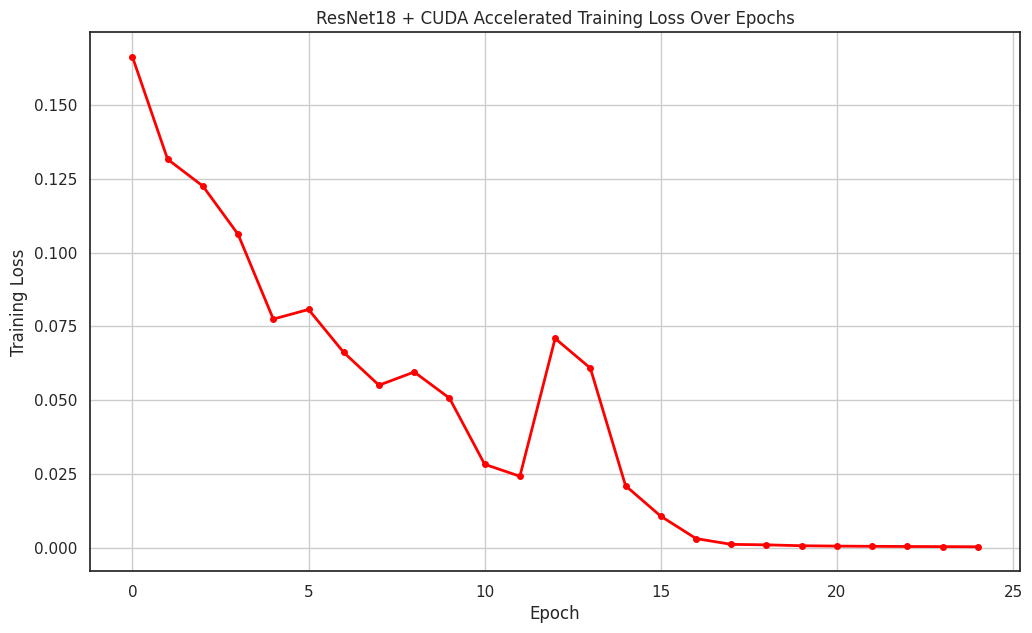

In [ ]:
# Extract keys and values from the dictionary
epochs = list(range(len(epoch_t_loss_cuda)))
loss_cuda_values = list(epoch_t_loss_cuda)

# Plotting the bar plot
fig, ax = plt.subplots(figsize=(12, 7))  # Set the figure size to create a square plot

ax.plot(epochs, loss_cuda_values, color='red', marker='.', linestyle='-', linewidth=2, markersize=8)

# Customize the plot
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title('ResNet18 + CUDA Accelerated Training Loss Over Epochs')
ax.grid(True)
plt.show()

## ResNet18 + MPI4Py + CUDA Accelerated (v1)

In [ ]:
# Intialize MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

In [ ]:
data_root = '/content/AI-for-Medicine-Specialization/AI-for-Medical-Diagnosis/nih/images_small'

transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Initialize MPI
# MPI.Init()
# comm = MPI.COMM_WORLD
# rank = comm.Get_rank()
# size = comm.Get_size()

# Set device based on MPI rank
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ...
num_channels = 3
num_classes = 14

# Define a pre-trained ResNet18 model
class PretrainedResNet18(nn.Module):
    def __init__(self, num_classes):
        super(PretrainedResNet18, self).__init__()
        resnet18 = models.resnet18(pretrained=True)
        # Remove the fully connected layers from the original ResNet18
        self.features = nn.Sequential(*list(resnet18.children())[:-2])
        # Add a new fully connected layer for your classification task
        self.classifier = nn.Linear(512, num_classes)  # Update this line

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])  # Global average pooling
        x = self.classifier(x)
        x = x.unsqueeze(1)
        return x

# Model, loss function, and optimizer
model = PretrainedResNet18(num_classes)
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 25
batch_size = 32

steps_t_loss_cuda = []
epoch_t_loss_cuda = []

# Data Parallelism with MPI
train_dataset = CustomDataset(root_dir=data_root+"/train-small", data=train_data, transform=transform)
train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset, num_replicas=size, rank=rank)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

# ...
test_dataset = CustomDataset(root_dir=data_root+"/test", data=test_data, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Mixed Precision Training
scaler = GradScaler()

# ...

# Training loop
print("Starting Training...")
start = time.time()
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    # ...
    print(f"[ Epoch {epoch + 1}/{num_epochs} ]\t Training Loss: {loss.item()}")
    epoch_t_loss_cuda.append(loss.item())

end = time.time()
print(f"Training Execution Time: {(end - start) / 60:.2f} minutes (min)")

# ...
model.eval()
total = 0
correct = 0

# Testing loop
print("Testing model...")
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += labels.size(0) * 14
        for i in range(labels.size(0)):
            correct += torch.sum(torch.eq(predicted[i], labels[i])).item()

accuracy = (correct / total) * 100
print(f"Test Accuracy: {accuracy}")

# Finalize MPI
# MPI.Finalize()

Using device: cuda
Starting Training...
[ Epoch 1/25 ]	 Training Loss: 0.16452017426490784
[ Epoch 2/25 ]	 Training Loss: 0.14218592643737793
[ Epoch 3/25 ]	 Training Loss: 0.13074682652950287
[ Epoch 4/25 ]	 Training Loss: 0.10552769154310226
[ Epoch 5/25 ]	 Training Loss: 0.11064723879098892
[ Epoch 6/25 ]	 Training Loss: 0.08069334179162979
[ Epoch 7/25 ]	 Training Loss: 0.07290741056203842
[ Epoch 8/25 ]	 Training Loss: 0.052181076258420944
[ Epoch 9/25 ]	 Training Loss: 0.036787163466215134
[ Epoch 10/25 ]	 Training Loss: 0.029365967959165573
[ Epoch 11/25 ]	 Training Loss: 0.01648840680718422
[ Epoch 12/25 ]	 Training Loss: 0.014407970011234283
[ Epoch 13/25 ]	 Training Loss: 0.004738284274935722
[ Epoch 14/25 ]	 Training Loss: 0.003567058127373457
[ Epoch 15/25 ]	 Training Loss: 0.00220878585241735
[ Epoch 16/25 ]	 Training Loss: 0.001251189038157463
[ Epoch 17/25 ]	 Training Loss: 0.0008760634809732437
[ Epoch 18/25 ]	 Training Loss: 0.0006163889775052667
[ Epoch 19/25 ]	 Train

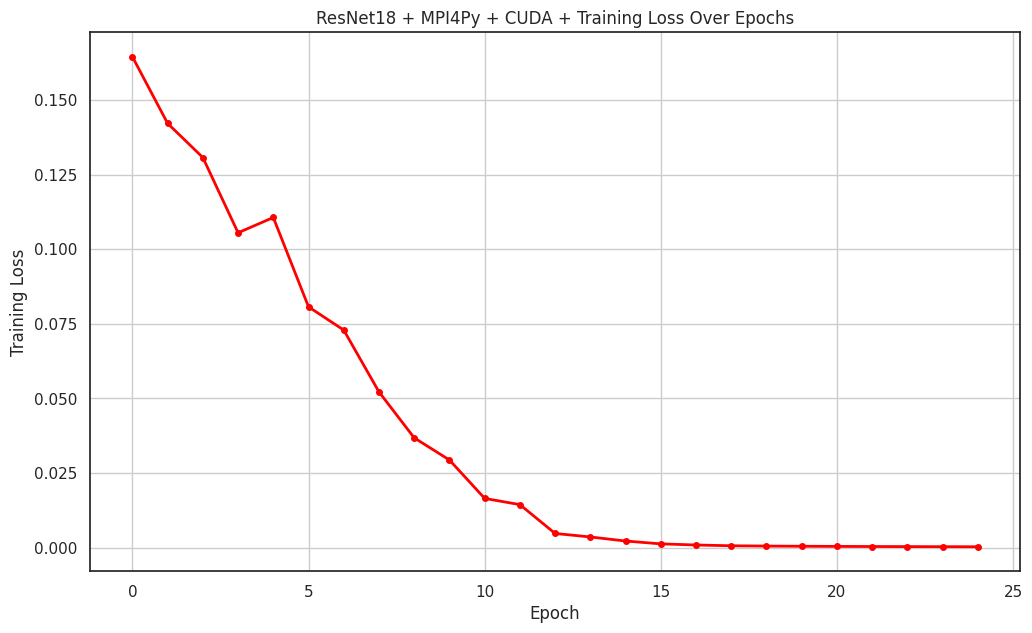

In [ ]:
# Extract keys and values from the dictionary
epochs = list(range(len(epoch_t_loss_cuda)))
loss_cuda_values = list(epoch_t_loss_cuda)

# Plotting the bar plot
fig, ax = plt.subplots(figsize=(12, 7))  # Set the figure size to create a square plot

ax.plot(epochs, loss_cuda_values, color='red', marker='.', linestyle='-', linewidth=2, markersize=8)

# Customize the plot
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title('ResNet18 + MPI4Py + CUDA + Training Loss Over Epochs')
ax.grid(True)
plt.show()

## ResNet18 + MPI4Py + CUDA Accelerated (v2)
### Added learning rate scheduler, mixed precision training (GradScaler)

In [ ]:
data_root = '/content/AI-for-Medicine-Specialization/AI-for-Medical-Diagnosis/nih/images_small'

transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Initialize MPI
# MPI.Init()
# comm = MPI.COMM_WORLD
# rank = comm.Get_rank()
# size = comm.Get_size()

# Set device based on MPI rank
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ...
num_channels = 3
num_classes = 14

# Define a pre-trained ResNet18 model
class PretrainedResNet18(nn.Module):
    def __init__(self, num_classes):
        super(PretrainedResNet18, self).__init__()
        resnet18 = models.resnet18(pretrained=True)
        # Remove the fully connected layers from the original ResNet18
        self.features = nn.Sequential(*list(resnet18.children())[:-2])
        # Add a new fully connected layer for your classification task
        self.classifier = nn.Linear(512, num_classes)  # Update this line

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])  # Global average pooling
        x = self.classifier(x)
        x = x.unsqueeze(1)
        return x

# Model, loss function, and optimizer
model = PretrainedResNet18(num_classes)
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, verbose=True)

# Training loop
num_epochs = 25
batch_size = 32

steps_t_loss_cuda = []
epoch_t_loss_cuda = []

# Data Parallelism with MPI
train_dataset = CustomDataset(root_dir=data_root+"/train-small", data=train_data, transform=transform)
train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset, num_replicas=size, rank=rank)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

# ...
test_dataset = CustomDataset(root_dir=data_root+"/test", data=test_data, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Mixed Precision Training
scaler = GradScaler()

# ...

# Training loop
print("Starting Training...")
start = time.time()
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    # Adjusting learing rate
    scheduler.step(loss)

    # ...
    print(f"[ Epoch {epoch + 1}/{num_epochs} ]\t Training Loss: {loss.item()}")
    epoch_t_loss_cuda.append(loss.item())

end = time.time()
print(f"Training Execution Time: {(end - start) / 60:.2f} minutes (min)")

# ...
model.eval()
total = 0
correct = 0

# Testing loop
print("Testing model...")
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += labels.size(0) * 14
        for i in range(labels.size(0)):
            correct += torch.sum(torch.eq(predicted[i], labels[i])).item()

accuracy = (correct / total) * 100
print(f"Test Accuracy: {accuracy}")

# Finalize MPI
# MPI.Finalize()

Using device: cuda
Starting Training...
[ Epoch 1/25 ]	 Training Loss: 0.16377586126327515
[ Epoch 2/25 ]	 Training Loss: 0.16262760758399963
[ Epoch 3/25 ]	 Training Loss: 0.13504473865032196
[ Epoch 4/25 ]	 Training Loss: 0.12220176309347153
[ Epoch 5/25 ]	 Training Loss: 0.10931707173585892
[ Epoch 6/25 ]	 Training Loss: 0.09901579469442368
[ Epoch 7/25 ]	 Training Loss: 0.08612069487571716
[ Epoch 8/25 ]	 Training Loss: 0.051076147705316544
[ Epoch 9/25 ]	 Training Loss: 0.04517240449786186
[ Epoch 10/25 ]	 Training Loss: 0.04007997363805771
[ Epoch 11/25 ]	 Training Loss: 0.02400398440659046
[ Epoch 12/25 ]	 Training Loss: 0.01718572899699211
[ Epoch 13/25 ]	 Training Loss: 0.00907010119408369
[ Epoch 14/25 ]	 Training Loss: 0.013605673797428608
[ Epoch 15/25 ]	 Training Loss: 0.0200671199709177
[ Epoch 16/25 ]	 Training Loss: 0.010417313314974308
[ Epoch 17/25 ]	 Training Loss: 0.0017254853155463934
[ Epoch 18/25 ]	 Training Loss: 0.000985825783573091
[ Epoch 19/25 ]	 Training Lo

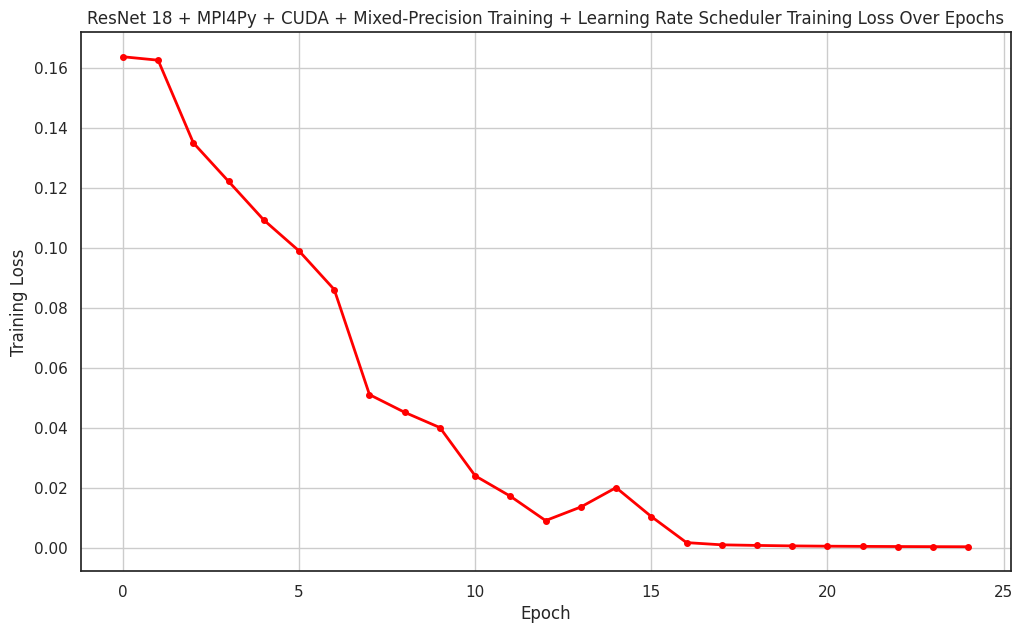

In [ ]:
# Extract keys and values from the dictionary
epochs = list(range(len(epoch_t_loss_cuda)))
loss_cuda_values = list(epoch_t_loss_cuda)

# Plotting the bar plot
fig, ax = plt.subplots(figsize=(12, 7))  # Set the figure size to create a square plot

ax.plot(epochs, loss_cuda_values, color='red', marker='.', linestyle='-', linewidth=2, markersize=8)

# Customize the plot
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title('ResNet 18 + MPI4Py + CUDA + Mixed-Precision Training + Learning Rate Scheduler Training Loss Over Epochs')
ax.grid(True)
plt.show()

## ResNet50 + MPI4Py + CUDA Accelerated
### Added learning rate scheduler, mixed precision

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from torchvision import models
import time
from mpi4py import MPI

data_root = '/content/AI-for-Medicine-Specialization/AI-for-Medical-Diagnosis/nih/images_small'

transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Initialize MPI
# MPI.Init()
# comm = MPI.COMM_WORLD
# rank = comm.Get_rank()
# size = comm.Get_size()

# Set device based on MPI rank
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ...
num_channels = 3
num_classes = 14

class ResNet50AndMore(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50AndMore, self).__init__()
        resnet50 = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet50.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(2048, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = x.unsqueeze(1)
        return x

# Model, loss function, and optimizer
model = ResNet50AndMore(num_classes)
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, verbose=True)

# Training loop
num_epochs = 25
batch_size = 32

steps_t_loss_cuda = []
epoch_t_loss_cuda = []

# Data Parallelism with MPI
train_dataset = CustomDataset(root_dir=data_root+"/train-small", data=train_data, transform=transform)
train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset, num_replicas=size, rank=rank)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

# ...
test_dataset = CustomDataset(root_dir=data_root+"/test", data=test_data, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Mixed Precision Training
scaler = GradScaler()

# ...

# Training loop
print("Starting Training...")
start = time.time()
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    # Adjusting learing rate
    scheduler.step(loss)

    # ...
    print(f"[ Epoch {epoch + 1}/{num_epochs} ]\t Training Loss: {loss.item()}")
    epoch_t_loss_cuda.append(loss.item())

end = time.time()
print(f"Training Execution Time: {(end - start) / 60:.2f} minutes (min)")

# ...
model.eval()
total = 0
correct = 0

# Testing loop
print("Testing model...")
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += labels.size(0) * 14
        for i in range(labels.size(0)):
            correct += torch.sum(torch.eq(predicted[i], labels[i])).item()

accuracy = (correct / total) * 100
print(f"Test Accuracy: {accuracy}")

# Finalize MPI
# MPI.Finalize()

Using device: cuda
Starting Training...
[ Epoch 1/25 ]	 Training Loss: 0.7382166981697083
[ Epoch 2/25 ]	 Training Loss: 0.6037063598632812
[ Epoch 3/25 ]	 Training Loss: 0.4059058129787445
[ Epoch 4/25 ]	 Training Loss: 0.3857261836528778
[ Epoch 5/25 ]	 Training Loss: 0.2693949043750763
[ Epoch 6/25 ]	 Training Loss: 0.19637762010097504
[ Epoch 7/25 ]	 Training Loss: 0.22758585214614868
[ Epoch 8/25 ]	 Training Loss: 0.25898343324661255
[ Epoch 9/25 ]	 Training Loss: 0.2021985501050949
Epoch 00010: reducing learning rate of group 0 to 1.0000e-04.
[ Epoch 10/25 ]	 Training Loss: 0.24579638242721558
[ Epoch 11/25 ]	 Training Loss: 0.21687352657318115
[ Epoch 12/25 ]	 Training Loss: 0.19599632918834686
[ Epoch 13/25 ]	 Training Loss: 0.1468920111656189
[ Epoch 14/25 ]	 Training Loss: 0.21860773861408234
[ Epoch 15/25 ]	 Training Loss: 0.20316989719867706
[ Epoch 16/25 ]	 Training Loss: 0.14068186283111572
[ Epoch 17/25 ]	 Training Loss: 0.20656782388687134
[ Epoch 18/25 ]	 Training Loss

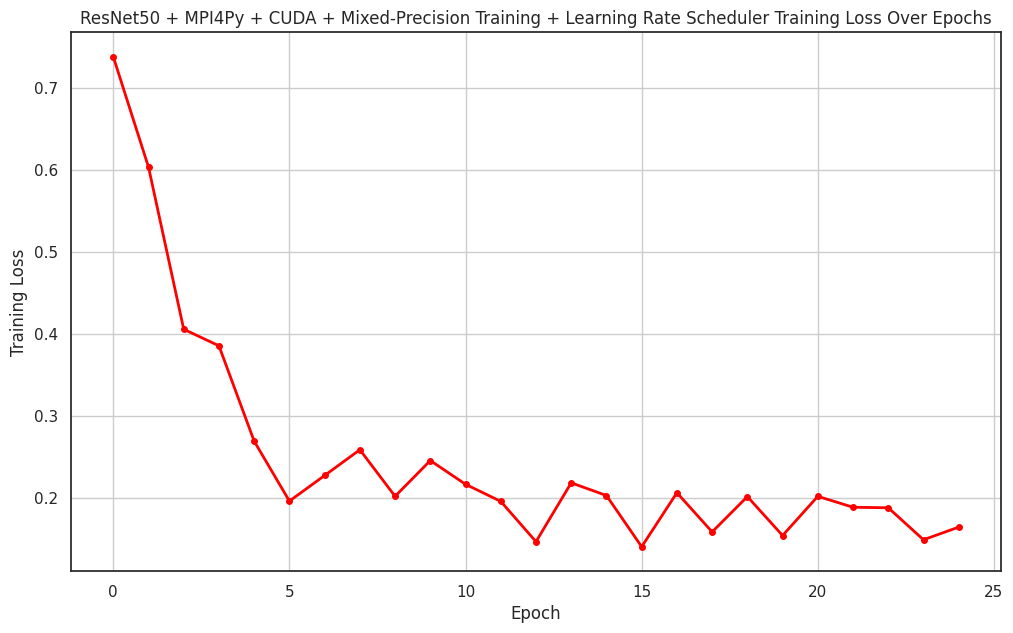

In [ ]:
# Extract keys and values from the dictionary
epochs = list(range(len(epoch_t_loss_cuda)))
loss_cuda_values = list(epoch_t_loss_cuda)

# Plotting the bar plot
fig, ax = plt.subplots(figsize=(12, 7))  # Set the figure size to create a square plot

ax.plot(epochs, loss_cuda_values, color='red', marker='.', linestyle='-', linewidth=2, markersize=8)

# Customize the plot
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title('ResNet50 + MPI4Py + CUDA + Mixed-Precision Training + Learning Rate Scheduler Training Loss Over Epochs')
ax.grid(True)
plt.show()